# C-Value - Private Landed Property
The next bound:

1. Combine multiple data sources:
    1. HDB information from [Data.gov.sg](https://data.gov.sg/dataset/hdb-property-information)
    2. Condo information from www.data.com.sg (also scrape this)
    3. Square Foot API
2. Time Series

In [1]:
# Import required modules
import dns_property as dns
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import seaborn as sns
import warnings

from numpy.random import seed
from lightgbm import LGBMRegressor
from os import listdir
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import RepeatedKFold, train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import MinMaxScaler, LabelEncoder

# Settings
warnings.filterwarnings('ignore')

## Import Data

In [2]:
# Read data
df = pd.read_csv('../Data/caveat_data_final.csv')
df = df[df.category=='Landed']

# Preview
df.head()

,sn,project_name,street_name,type,postal_district,market_segment,tenure,type_of_sale,no_of_units,price,nett_price,area_sqft,type_of_area,floor_level,target,date_of_sale,category,remaining_lease,freehold,age
55422,1,LANDED HOUSING DEVELOPMENT,FABER HEIGHTS,Semi-detached,5,OCR,Freehold,Resale,1.0,5150000.0,-,4053.0,Land,-,1271.0,Aug-2019,Landed,9999,1,34
55423,2,LANDED HOUSING DEVELOPMENT,PASIR PANJANG ROAD,Semi-detached,5,RCR,Freehold,Resale,1.0,2718000.0,-,2530.0,Land,-,1075.0,Jul-2019,Landed,9999,1,34
55424,3,LANDED HOUSING DEVELOPMENT,PASIR PANJANG ROAD,Terrace,5,RCR,Freehold,Resale,1.0,3100000.0,-,1886.0,Land,-,1644.0,Jul-2019,Landed,9999,1,34
55425,4,FABER HILLS,FABER GREEN,Terrace,5,OCR,Freehold,Resale,1.0,3025000.0,-,2102.0,Land,-,1439.0,Jul-2019,Landed,9999,1,34
55426,5,LANDED HOUSING DEVELOPMENT,OCEAN DRIVE,Terrace,4,CCR,99 yrs lease commencing from 2004,Resale,1.0,5700000.0,-,3316.0,Land,-,1719.0,Jun-2019,Landed,84,0,15


## Feature Engineering

In [3]:
# Create month
df['mth'] = pd.to_datetime(df['date_of_sale'])

In [4]:
# # Generate month lags
# for var in ['type', 'market_segment', 'postal_district', 'street_name', 'project_name', 'freehold']:

#     df = dns.fe_mth(df, var, 1)
#     df = dns.fe_qtr(df, var, 1)

In [5]:
df.columns

Index(['sn', 'project_name', 'street_name', 'type', 'postal_district',
       'market_segment', 'tenure', 'type_of_sale', 'no_of_units', 'price',
       'nett_price', 'area_sqft', 'type_of_area', 'floor_level', 'target',
       'date_of_sale', 'category', 'remaining_lease', 'freehold', 'age',
       'mth'],
      dtype='object')

In [6]:
df.head()

,sn,project_name,street_name,type,postal_district,market_segment,tenure,type_of_sale,no_of_units,price,...,area_sqft,type_of_area,floor_level,target,date_of_sale,category,remaining_lease,freehold,age,mth
55422,1,LANDED HOUSING DEVELOPMENT,FABER HEIGHTS,Semi-detached,5,OCR,Freehold,Resale,1.0,5150000.0,...,4053.0,Land,-,1271.0,Aug-2019,Landed,9999,1,34,2019-08-01
55423,2,LANDED HOUSING DEVELOPMENT,PASIR PANJANG ROAD,Semi-detached,5,RCR,Freehold,Resale,1.0,2718000.0,...,2530.0,Land,-,1075.0,Jul-2019,Landed,9999,1,34,2019-07-01
55424,3,LANDED HOUSING DEVELOPMENT,PASIR PANJANG ROAD,Terrace,5,RCR,Freehold,Resale,1.0,3100000.0,...,1886.0,Land,-,1644.0,Jul-2019,Landed,9999,1,34,2019-07-01
55425,4,FABER HILLS,FABER GREEN,Terrace,5,OCR,Freehold,Resale,1.0,3025000.0,...,2102.0,Land,-,1439.0,Jul-2019,Landed,9999,1,34,2019-07-01
55426,5,LANDED HOUSING DEVELOPMENT,OCEAN DRIVE,Terrace,4,CCR,99 yrs lease commencing from 2004,Resale,1.0,5700000.0,...,3316.0,Land,-,1719.0,Jun-2019,Landed,84,0,15,2019-06-01


## Conventional CV

In [7]:
# Private Vars
drop_vars_pri = ['sn', 'tenure', 'no_of_units', 'price', 'nett_price', 'floor_level', 'target', 'date_of_sale', 'category', 'mth']
vars_pri_bin = ['type', 'type_of_sale', 'type_of_area', 'market_segment', 'postal_district']

# Configure data
X_data = pd.get_dummies(df.drop(drop_vars_pri, axis=1),
                        columns=vars_pri_bin)
y_data = df['target']

# Configure CV
cv = RepeatedKFold(n_splits=5, n_repeats=1, random_state=100)

# Initialise models
lg = LGBMRegressor(n_estimators=1000, num_leaves=50, max_depth=10, random_state=123, n_jobs=4, reg_alpha=0.1, reg_lambda=0.9)
kn = KNeighborsRegressor(n_neighbors=10, weights='distance', n_jobs=4)

# Configure stop words
stop_words = [
    'road', 'avenue', 'street', 'drive', 'lorong', 'crescent', 'view', 'rise'
    'jalan', 'lane', 'walk', 'link', 'bukit',
    'rd', 'ave', 'st', 'dr', 'lor', 'cres', 'jln', 'pl'
]

### K-NN

In [8]:
kn_cv = dns.custom_cv(kn, X_data, y_data, cv, ['project_name', 'street_name'], stop_words, norm=True, ppd=True)

# ---- COMPUTING C-VALUE ---- #
Running iteration 1 of 5...
Running iteration 2 of 5...
Running iteration 3 of 5...
Running iteration 4 of 5...
Running iteration 5 of 5...

[MODEL STATISTICS]
M-PPD: 8.33%
PPD Deviation:
  +-5.0%: 35.63%
  +-10%: 55.54%
  +-20%: 78.45%

MAPE: 13.95%
MAE: $160
RMSE: $248
R2: 67.36%


### LightGBM

In [9]:
lg_cv = dns.custom_cv(lg, X_data, y_data, cv, ['project_name', 'street_name'], stop_words, ppd=True)

# ---- COMPUTING C-VALUE ---- #
Running iteration 1 of 5...
Running iteration 2 of 5...
Running iteration 3 of 5...
Running iteration 4 of 5...
Running iteration 5 of 5...

[MODEL STATISTICS]
M-PPD: 7.88%
PPD Deviation:
  +-5.0%: 34.94%
  +-10%: 58.52%
  +-20%: 82.71%

MAPE: 11.97%
MAE: $142
RMSE: $217
R2: 74.85%


## Step-Forward Testing

In [10]:
# Private Vars
drop_vars_pri = ['sn', 'tenure', 'no_of_units', 'price', 'nett_price', 'floor_level', 'target', 'date_of_sale', 'category']
vars_pri_bin = ['type', 'type_of_sale', 'type_of_area', 'market_segment', 'postal_district']

# Configure data
X_data = pd.get_dummies(df.drop(drop_vars_pri, axis=1),
                        columns=vars_pri_bin)
y_data = df['target']

# Configure CV
cv = RepeatedKFold(n_splits=5, n_repeats=1, random_state=100)

# Initialise models
lg = LGBMRegressor(n_estimators=1000, num_leaves=50, max_depth=10, random_state=123, n_jobs=4, reg_alpha=0.1, reg_lambda=0.9)
kn = KNeighborsRegressor(n_neighbors=10, weights='distance', n_jobs=4)

# Configure stop words
stop_words = [
    'road', 'avenue', 'street', 'drive', 'lorong', 'crescent', 'view', 'rise'
    'jalan', 'lane', 'walk', 'link', 'bukit',
    'rd', 'ave', 'st', 'dr', 'lor', 'cres', 'jln', 'pl'
]

### K-NN

# ---- COMPUTING C-VALUE ---- #
Running iteration 1 of 12...
Running iteration 2 of 12...
Running iteration 3 of 12...
Running iteration 4 of 12...
Running iteration 5 of 12...
Running iteration 6 of 12...
Running iteration 7 of 12...
Running iteration 8 of 12...
Running iteration 9 of 12...
Running iteration 10 of 12...
Running iteration 11 of 12...
Running iteration 12 of 12...



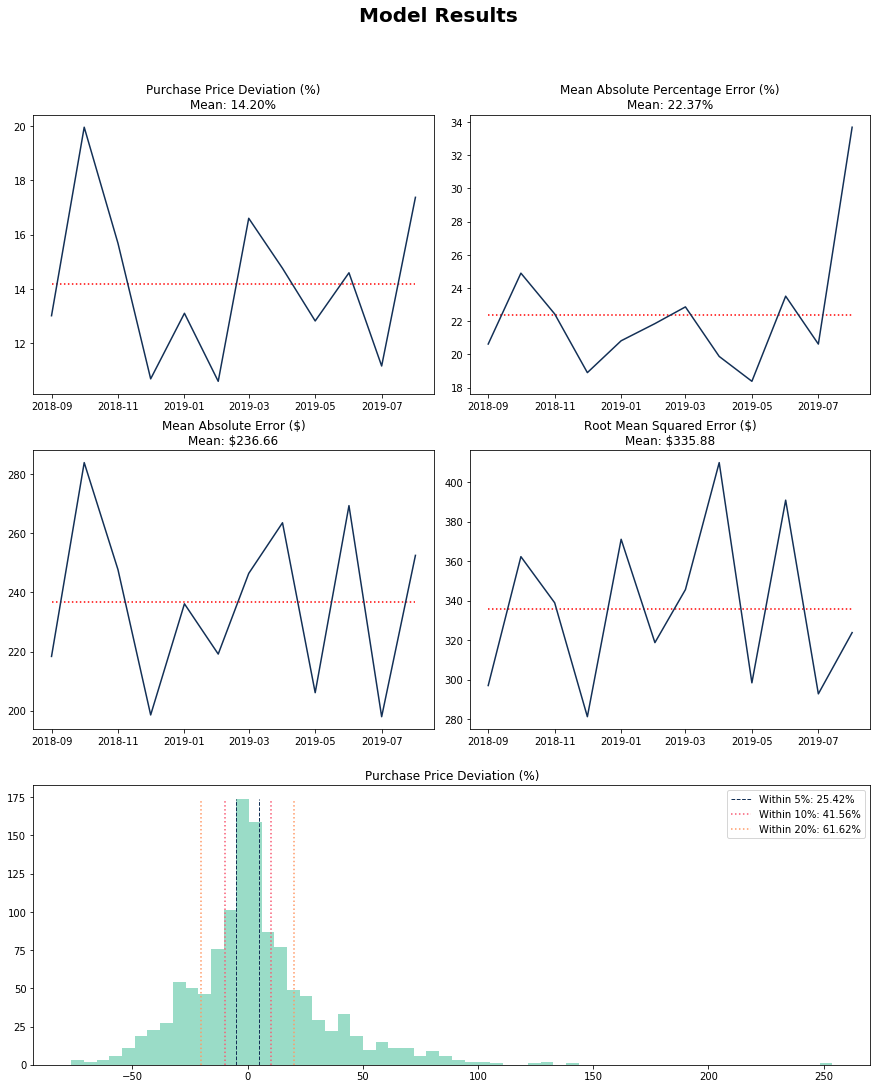

[MODEL STATISTICS]
M-PPD: 14.20%
PPD Deviation:
  +-5.0%: 26.01%
  +-10%: 41.20%
  +-20%: 61.47%

MAPE: 22.37%
MAE: $237
RMSE: $336
R2: 38.96%


In [11]:
kn_cv = dns.custom_ts(rgr=kn, X=X_data, y=y_data, timevar='mth', start='2018-09-01', tfidf_cols=['project_name', 'street_name'], stop_words=stop_words, dropout=0.1, ppd=True, random_state=100)

### LightGBM

# ---- COMPUTING C-VALUE ---- #
Running iteration 1 of 12...
Running iteration 2 of 12...
Running iteration 3 of 12...
Running iteration 4 of 12...
Running iteration 5 of 12...
Running iteration 6 of 12...
Running iteration 7 of 12...
Running iteration 8 of 12...
Running iteration 9 of 12...
Running iteration 10 of 12...
Running iteration 11 of 12...
Running iteration 12 of 12...



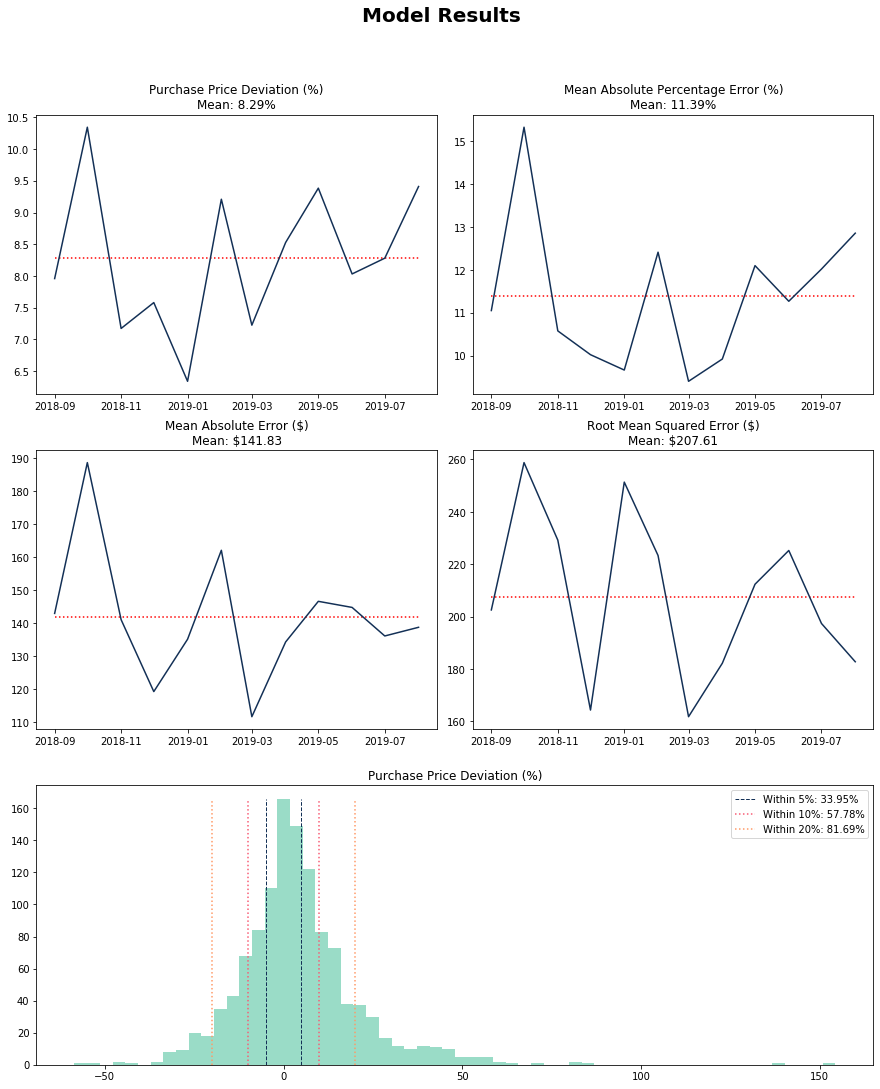

[MODEL STATISTICS]
M-PPD: 8.29%
PPD Deviation:
  +-5.0%: 33.46%
  +-10%: 57.49%
  +-20%: 81.76%

MAPE: 11.39%
MAE: $142
RMSE: $208
R2: 76.13%


In [12]:
lg_cv = dns.custom_ts(rgr=lg, X=X_data, y=y_data, timevar='mth', start='2018-09-01', tfidf_cols=['project_name', 'street_name'], stop_words=stop_words, dropout=0.1, ppd=True, random_state=100)